In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10,8
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [13]:
def Creat_Model():
    model = {
        "Dense1":Dense(100,activation='tanh'),
        'Dense2':Dense(100,activation='tanh'),
        "Dense3":Dense(50,activation='tanh'),
        'Output':Dense(units=1,activation='sigmoid')
    }
    return model

In [14]:
def Call_Model(model,X):
    X = model['Dense1'](X)
    X = model['Dense2'](X)
    X = model['Dense3'](X)
    X = model['Output'](X)

    return X
    

In [15]:
def PDE(X,model):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        y_pred = Call_Model(model,X)
        y_X = tape.gradient(y_pred,X)
        y_XX = tape.gradient(y_X,X)

        del tape

        return y_XX + np.pi**2 * tf.sin(np.pi * X)

In [16]:
def Loss_Function(model,X,X_bc,y_bc):
    residuals = PDE(X,model)
    loss_PDE = tf.reduce_mean(tf.square(residuals))
    y_bc_pred = Call_Model(model,X_bc)
    loss_bc = tf.reduce_mean(tf.square(y_bc - y_bc_pred))

    return loss_PDE + loss_bc

In [17]:
def Train_Step(model,X,X_bc,y_bc,optimizer):
    with tf.GradientTape() as tape:
        loss_value = Loss_Function(model,X,X_bc,y_bc)
    gradiants = tape.gradient(loss_value,[layer.trainable_variables for layer in model.values()])
    gradiants = [grads for sublist in gradiants for grads in sublist]
    variables = [var for layer in model.values() for var in layer.trainable_variables]
    optimizer.apply_gradients(zip(gradiants,variables))

    return loss_value

In [18]:
X_train = np.linspace(-1,1,100).reshape(-1,1)
X_train = tf.convert_to_tensor(X_train,dtype=tf.float32)

X_bc = np.array([[-1.0],[1.0]],dtype=np.float32)
X_bc = tf.convert_to_tensor(X_bc,dtype=tf.float32)

y_bc = np.array([[0.0],[1.0]],dtype=np.float32)
X_bc = tf.convert_to_tensor(y_bc,dtype=tf.float32)



In [19]:
model = Creat_Model()
scheduler = ExponentialDecay(initial_learning_rate=1e-5,
                             decay_steps = 10000,
                             decay_rate = 0.9)
optimizer = Adam(learning_rate=scheduler)

In [20]:
epoches = 2000
for epoch in range(epoches):
    loss_value = Train_Step(model,X_train,X_bc,y_bc,optimizer)
    if epoch %1 ==0 & epoch %1000 ==0:
        print(f"Epoch: {epoch} loss: {loss_value.numpy()}")

Epoch: 0 loss: 48.42356491088867
Epoch: 1 loss: 48.42194747924805
Epoch: 2 loss: 48.420318603515625
Epoch: 3 loss: 48.418697357177734
Epoch: 4 loss: 48.41706466674805
Epoch: 5 loss: 48.41543197631836
Epoch: 6 loss: 48.41378402709961
Epoch: 7 loss: 48.412139892578125
Epoch: 8 loss: 48.410491943359375
Epoch: 9 loss: 48.408836364746094
Epoch: 10 loss: 48.407169342041016
Epoch: 11 loss: 48.40550231933594
Epoch: 12 loss: 48.40382385253906
Epoch: 13 loss: 48.40214157104492
Epoch: 14 loss: 48.40045166015625
Epoch: 15 loss: 48.39875411987305
Epoch: 16 loss: 48.397056579589844
Epoch: 17 loss: 48.39533996582031
Epoch: 18 loss: 48.39363479614258
Epoch: 19 loss: 48.391910552978516
Epoch: 20 loss: 48.390174865722656
Epoch: 21 loss: 48.38843536376953
Epoch: 22 loss: 48.386680603027344
Epoch: 23 loss: 48.38492202758789
Epoch: 24 loss: 48.383155822753906
Epoch: 25 loss: 48.38138198852539
Epoch: 26 loss: 48.37959289550781
Epoch: 27 loss: 48.377803802490234
Epoch: 28 loss: 48.37599182128906
Epoch: 29 lo

In [21]:
X_test = np.linspace(-1,1,1000).reshape(-1,1)
X_test = tf.convert_to_tensor(X_test,dtype=tf.float32)

y_pred = Call_Model(model,X_test).numpy()
y_true = np.sin(np.pi * X_test)

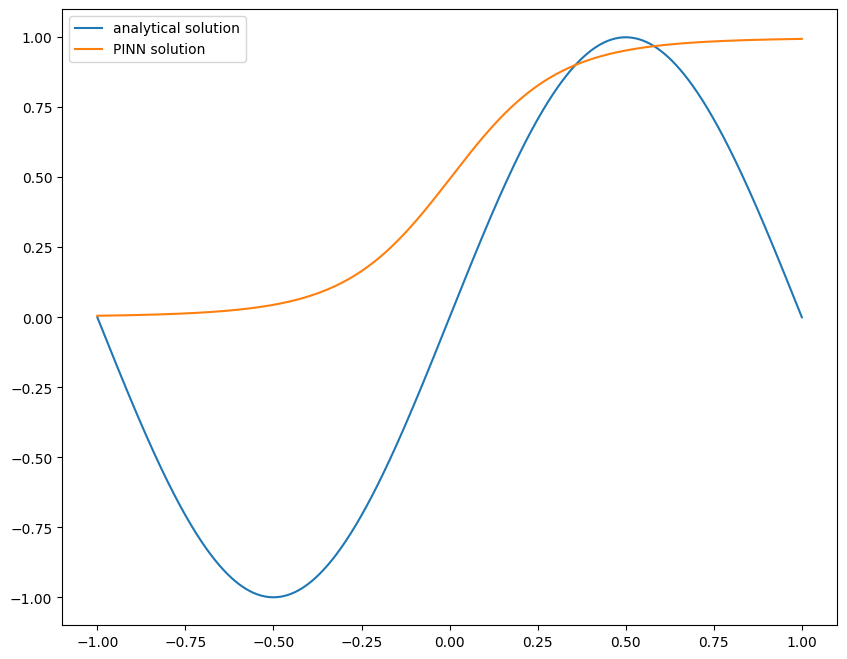

In [22]:
plt.plot(X_test,y_true, label = 'analytical solution')
plt.plot(X_test,y_pred, label = 'PINN solution')
plt.legend()
plt.show()